### **1. Mario'nun Kurulumu**

In [ ]:
!pip install gym_super_mario_bros==7.3.0 nes_py

Alt kısımda ilk satırımızda oyunun kütüphanesini import ediyoruz. İkinci satırında ise bize oyunu oynamamız için bir konsol sağlayacak bir kütüphaneyi import ediyoruz.

En alttaki ise diğerlerinden farklı olarak Mario oyunundaki basit hareketleri import ediyor.

In [11]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

Alt kısımda oyunumuzu 'env' değişkeni altında başlatıp buna bir JoypadSpace ekliyoruz.

JoypadSpace eklememiz oyundaki hamleleri basitleştirip azaltıyor. Normalde ilk satırdaki tanımladığımızda env.action.space 256 iken JoypadeSpace komutu ile bu üstteki SIMPLE_MOVEMENT kısmı ile 7'ye düşüyor...

In [12]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

Alttaki kısımda ise env'imiz ile oyunu rastgele hamlelerle oynamaya çalışıyoruz. 

https://pypi.org/project/gym-super-mario-bros/ sitesinden env, hareketler, oynanabilecek versiyonlar ve diğerleri hakkında daha detaylı bilgi edinilebilir.

In [13]:
done = True
for step in range(3000): 
    if done: 
        env.reset()
    # Rastgele hareketler yapıyor...
    state, reward, done, info = env.step(env.action_space.sample())
    # Oyunu ekrana yansıtmak için kullanılıyor...
    env.render()
env.close()

c:\Users\mehmu\Desktop\PythonProjects\kernel\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] İş parçacığı modu kurulduktan sonra değiştirilemez
  warnings.warn(str(err))
c:\Users\mehmu\Desktop\PythonProjects\kernel\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


### **2. Env Hazırlıkları**

In [ ]:
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [ ]:
!pip install stable-baselines3[extra]

Alttaki kodlardan ilk satırdaki **FrameStack** aynı anda birden fazla görüntü(frame) tutmamıza yarıyor. Bu aslında modelin şuan için karar vermesinden genel olarak geçmişini de göz önünde bulundurarak karar vermesini sağlıyor.

**GrayScaleObservation** ise renklerden dolayı 3 kanaldan alınacak bilgiyi 1 kanala düşürüyor. Bu bizim işlemden tasarruf etmemizi sağlıyor.

In [14]:
from gym.wrappers import FrameStack, GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack,DummyVecEnv
import matplotlib.pyplot as plt

In [15]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

Görüldüğü üzere **GrayScaleObservation** ile kanalımız 3'ten 1'e düştü...

(240, 256, 3)


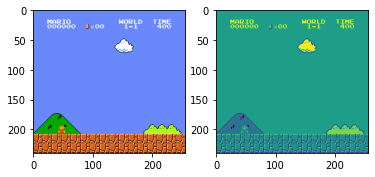

In [16]:
print(env.reset().shape)
plt.subplot(1,2,1)
plt.imshow(env.reset())

env=GrayScaleObservation(env,keep_dim=True)
env.reset().shape
plt.subplot(1,2,2)
plt.imshow(env.reset())

Env'ımıza kaç tane frame tutacağını söylüyoruz. Burada bu değer 4...

In [17]:
env=DummyVecEnv([lambda:env])
env=VecFrameStack(env,4,channels_order='last')

### **3. Eğitim Aşaması**

PPO bizim reinforcement için kullanacağımız model.

BaseCallback'i de import etmemin nedeni modellerin performanslarının farklı olacağından belli bir periyotta en iyi modeli kaydetmek...

In [18]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import os

Burada callback olarak tanımlıyor ve ne istediğimizi söylüyoruz...

In [19]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

Kaydetmelerimizi yapacağımız yerleri giriyoruz.

In [20]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

callback'imiz için hangi sıklıkla ve nereye kaydedeceğimizi giriyoruz...

In [21]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)
# CnnLstmPolicy, MlpPolicy
model=PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=1e-6, 
            n_steps=512) 

Using cuda device
Wrapping the env in a VecTransposeImage.


In [ ]:
model.learn(total_timesteps=1000000, callback=callback)

Elde ettiğimiz değerleri alttaki komut ile görebiliriz.

Kodları cmd ile eğitim aşamasında da görebilirsiniz...

In [ ]:
!cd logs/PPO_3
!tensorboard --logdir=.

### **4. Test Aşaması**

İstediğimiz modeli seçiyoruz ve çalıştırıyoruz.

Modeller genelde 600k 700k nın üzerindeyken daha iyi performans gösteriyor...

In [ ]:
model = PPO.load('./train/best_model_1000000')

state = env.reset()

In [ ]:
state = env.reset()
while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()